In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from scipy.integrate import solve_ivp

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u

    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

        
    def _reaction(self, y):
        """
        Compute the reaction term in real space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        u = y[:self.nx*self.ny]
        v = y[-self.nx*self.ny:]
        mix_term = u*(v**2)
        return np.hstack([-mix_term + self.b*(1-u), mix_term - self.kappa*v])



    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
        y = y.reshape((self.nx, self.ny))
        k = np.fft.fft2(y)
        return np.real(np.fft.ifft2(-self.ksq*k)).flatten()

    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        u = y[:self.nx*self.ny]
        v = y[-self.nx*self.ny:]
        return np.hstack([self.du*self._laplace(u), self.dv*self._laplace(v)])



    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        return self._reaction(y) + self._diffusion(y)


    def solve(self, u0, v0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver

        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp

        """
        y0 = np.hstack([u0.flatten(), v0.flatten()])
        out = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=np.linspace(t_min, t_max, nt), **kwargs)
        sol = out.y.T
        
        u, v = sol[:, :self.nx * self.ny], sol[:, self.nx * self.ny:]
        u = np.reshape(u, (nt, self.ny, self.nx))
        v = np.reshape(v, (nt, self.ny, self.nx))
        return np.linspace(t_min, t_max, nt), np.stack([u, v], axis=-1)
        






### Test and use your code

You don't need to write any code below, these cells are just to confirm that everything is working and to play with your implementation

In [ ]:
# Import William's solution
# from solutions.grayscott import GrayScott

## Create initial conditions
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((50, 50))
v_ic = 1 - np.copy(u_ic)

## Run simulation
model = GrayScott(*u_ic.shape)
tpts, sol = model.solve(u_ic, v_ic, 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

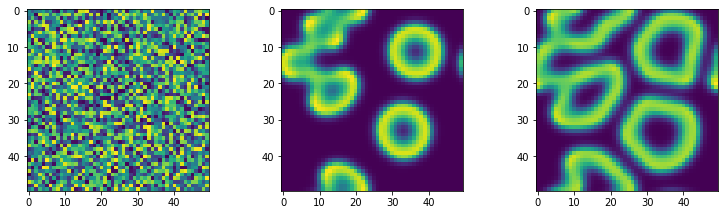

In [55]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(sol[0, ..., 1])
plt.subplot(1, 3, 2)
plt.imshow(sol[50, ..., 1])
plt.subplot(1, 3, 3)
plt.imshow(sol[100, ..., 1])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

**Testing for $D_u = 0$**

In [29]:
model = GrayScott(*u_ic.shape, du = 0)
tpts, sol = model.solve(u_ic, v_ic, 0, 5000, 500)
sol = np.real(sol)

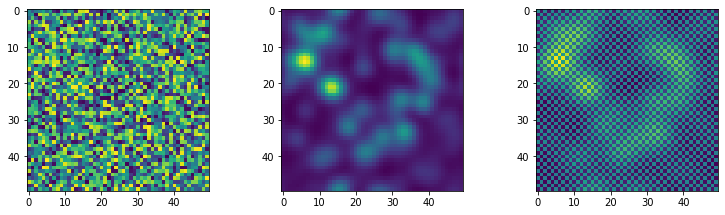

In [47]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(sol[0, ..., 1])
plt.subplot(1, 3, 2)
plt.imshow(sol[5, ..., 1])
plt.subplot(1, 3, 3)
plt.imshow(sol[10, ..., 1])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

**Testing for $D_v = 0$**

In [48]:
model2 = GrayScott(*u_ic.shape, dv = 0)
tpts, sol2 = model2.solve(u_ic, v_ic, 0, 5000, 500)
sol2 = np.real(sol2)

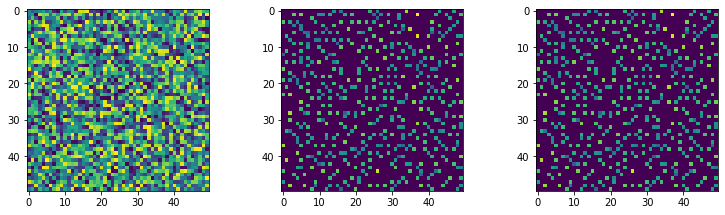

In [50]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(sol2[0, ..., 1])
plt.subplot(1, 3, 2)
plt.imshow(sol2[100, ..., 1])
plt.subplot(1, 3, 3)
plt.imshow(sol2[200, ..., 1])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

**Testing for $\beta = 0$**

In [51]:
model3 = GrayScott(*u_ic.shape, b = 0)
tpts, sol3 = model3.solve(u_ic, v_ic, 0, 5000, 500)
sol3 = np.real(sol3)

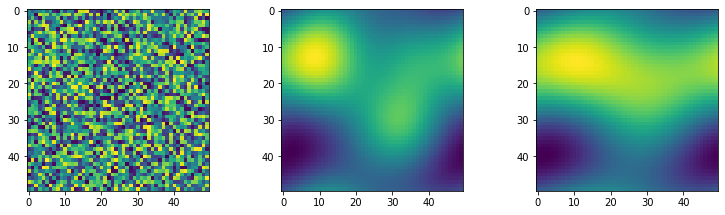

In [52]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(sol3[0, ..., 1])
plt.subplot(1, 3, 2)
plt.imshow(sol3[100, ..., 1])
plt.subplot(1, 3, 3)
plt.imshow(sol3[200, ..., 1])
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()